In [47]:
import ROOT
import numpy as np

In [48]:
def y(particle):
    return np.log((particle.E + particle.pz) / (particle.E - particle.pz))

def lambda_ab(particle_a,particle_b):
    delta_y = y(particle_a) - y(particle_b)
    delta_phi = particle_a.phi - particle_b.phi

    return np.sqrt(delta_y**2 + delta_phi**2)

def z(particle2, particle1):
    return particle1.pt / (particle1.pt + particle2.pt)

def mass_calculator(particle):
    return np.sqrt(particle.E**2 - particle.px**2 - particle.py**2 - particle.pz**2)

def m(particle_a, particle_b):
    m_squared = mass_calculator(particle_a)**2 + mass_calculator(particle_b)**2 + 2*(particle_a.E*particle_b.E - particle_a.px*particle_b.px - particle_a.py*particle_b.py - particle_a.pz*particle_b.pz)
    return np.sqrt(m_squared)

def psi(particle_a, particle_b):
    delta_y = y(particle_b) - y(particle_a)
    delta_phi = particle_b.phi - particle_a.phi
    return np.arctan(delta_y/delta_phi)

def k_t(particle_a, particle_b):
    return particle_b.pt * lambda_ab(particle_a, particle_b)

def kappa(particle_a, particle_b):
    return z(particle_a, particle_b) * lambda_ab(particle_a, particle_b)

def dic_var(particle_a, particle_b):
    l = lambda_ab(particle_a, particle_b)
    k = k_t(particle_a, particle_b)
    mass = m(particle_a, particle_b)
    ze = z(particle_a, particle_b)
    k_o = kappa(particle_a, particle_b)
    psi_ab = psi(particle_a, particle_b)

    dic_vars = {lambda_ab: l, k_t: k, m: mass, z: ze, kappa: k_o, psi: psi_ab}

    return dic_vars

def compare_jets(jet1, jet2):
    return jet1.px == jet2.px and jet1.py == jet2.py and jet1.pz == jet2.pz and jet1.E == jet2.E

In [49]:
file_path = "../root/out_1ED582EB-116D-7D4A-ACD3-B1FDD875261D.root"

file = ROOT.TFile.Open(file_path)
tree = file.Get("jetTree")

n_entries = tree.GetEntries()
print(f"Number of entries in the tree: {n_entries}")

Number of entries in the tree: 136299


In [50]:
#plot ak4 jet pt
import matplotlib.pyplot as plt
ak4_pts = []
nob_pts = []
b_pts = []
btag_list = []
for entry in range(n_entries):
    tree.GetEntry(entry)
    for jet_i in range(len(tree.jet_pt)):
        bscore = tree.jet_btag[jet_i]
        if tree.jetAK[jet_i] == 4 and tree.jet_pt[jet_i] > 200:
            ak4_pts.append(tree.jet_pt[jet_i])
            btag_list.append(bscore)
            if bscore > 0.8:
                b_pts.append(tree.jet_pt[jet_i])
            else:
                nob_pts.append(tree.jet_pt[jet_i])

print(f"Total number of jets: {len(ak4_pts)}")
print(f"Total number of b-jets: {len(b_pts)}")
print(f"Total number of non-b-jets: {len(nob_pts)}")

Total number of jets: 134417
Total number of b-jets: 9020
Total number of non-b-jets: 125397


[]

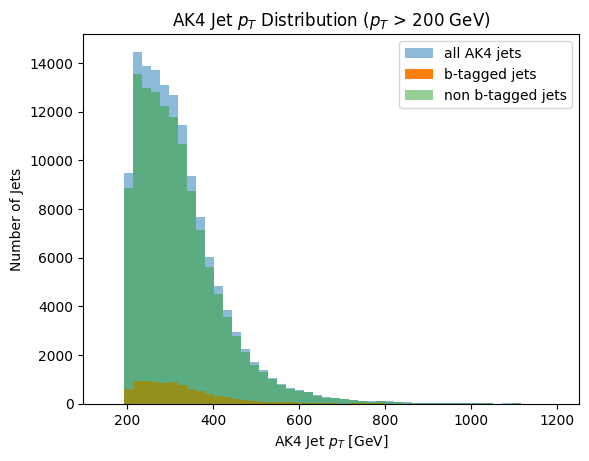

In [51]:
plt.hist(ak4_pts, bins=50, range=(150, 1200),label='all AK4 jets', alpha=0.5)
plt.hist(b_pts, bins=50, range=(150, 1200), alpha=1, label='b-tagged jets')
plt.hist(nob_pts, bins=50, range=(150, 1200), alpha=0.5, label='non b-tagged jets')
plt.legend()
plt.xlabel("AK4 Jet $p_{T}$ [GeV]")
plt.ylabel("Number of Jets")
plt.title("AK4 Jet $p_{T}$ Distribution ($p_{T}$ > 200 GeV)")

plt.plot()

[]

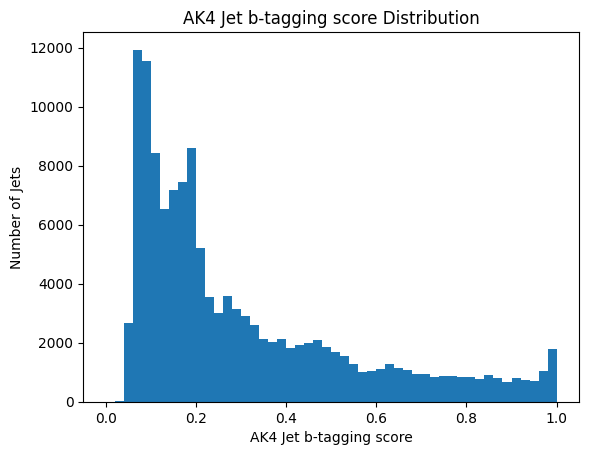

In [52]:
plt.hist(btag_list, bins=50, range=(0, 1))
plt.xlabel("AK4 Jet b-tagging score")
plt.ylabel("Number of Jets")
plt.title("AK4 Jet b-tagging score Distribution")

plt.plot()

Number of entries in the tree: 2937
Number of jets processed: 30224
X axis range: 0.776842007487325 to 9.238583730816531
Y axis range: -7.537715796128226 to 4.453954956320983


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


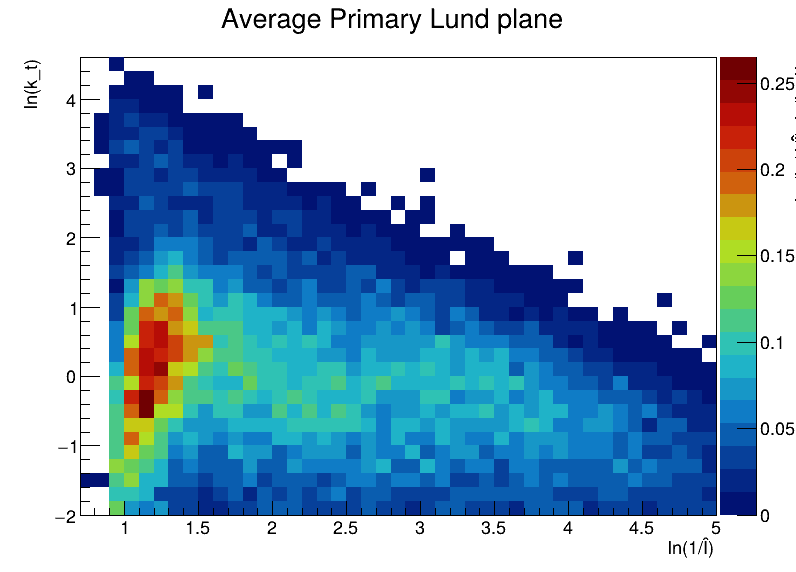

In [53]:
file_path = "../root/out_94C50CE8-43B0-AF4D-A8AE-BE0C7EC09B80.root"

file = ROOT.TFile.Open(file_path)
tree = file.Get("jetTree")

n_entries = tree.GetEntries()
print(f"Number of entries in the tree: {n_entries}")

#Create 2D histogram
hist = ROOT.TH2F("hist", "Average Primary Lund plane", 100, 0, 10, 100, -10, 10)
hist.GetXaxis().SetTitle("ln(1/Δ)")
hist.GetYaxis().SetTitle("ln(k_t)")
hist.GetZaxis().SetTitle("rho(ln(1/Δ), ln(k_t))")
max_x = -float('inf')
min_x = float('inf')
max_y = -float('inf')
min_y = float('inf')

njets = 0
for event in range(n_entries):
    tree.GetEntry(event)
    for jet_i in range(len(tree.jet_pt)):
        if tree.jetAK[jet_i] == 8 or tree.jet_pt[jet_i] < 200:
            if tree.jetAK[jet_i] != 8:
                njets += 1
            continue
        for i in range(len(tree.lund_coords_x[jet_i])):
            x = tree.lund_coords_x[jet_i][i]
            y = tree.lund_coords_y[jet_i][i]

            if x > max_x:
                max_x = x
            if x < min_x:
                min_x = x
            if y > max_y:
                max_y = y
            if y < min_y:
                min_y = y
            
            hist.Fill(x, y) 
print(f"Number of jets processed: {njets}")
#Remove stat box
ROOT.gStyle.SetOptStat(0)

#Rescale the histogram bins to the observed min and max values
print(f"X axis range: {min_x} to {max_x}")
print(f"Y axis range: {min_y} to {max_y}")
if min_x < 0:
    min_x = 0
if max_x > 5:
    max_x = 5
if min_y < -2:
    min_y = -2
if max_y > 7:
    max_y = 7

hist.GetXaxis().SetRangeUser(min_x, max_x)
hist.GetYaxis().SetRangeUser(min_y, max_y)

if njets > 0:
    bwx = hist.GetXaxis().GetBinWidth(1)
    bwy = hist.GetYaxis().GetBinWidth(1)
    #hist.Scale(1.0 / (njets * bwx * bwy))
    hist.Scale(1.0 / (njets * bwx * bwy))

#Change color palette
ROOT.gStyle.SetPalette(ROOT.kRainbow)

#Plotting
canvas = ROOT.TCanvas("canvas", "Average Primary Lund Plane", 800, 600)
hist.Draw("COLZ")
canvas.Draw()

# With SoftDrop

Number of jets processed: 30224
X axis range: 0.832560861138551 to 9.238583730816531
Y axis range: -7.537715796128226 to 4.453954956320983


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_sd


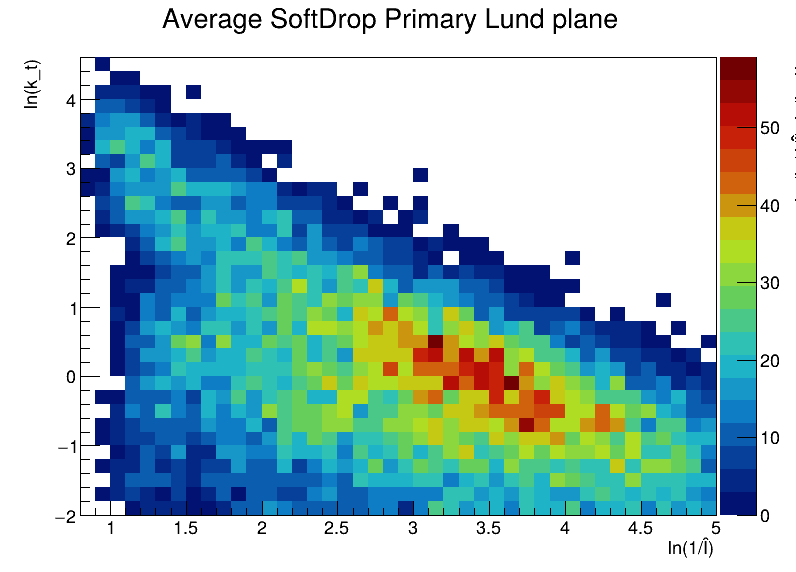

In [54]:
#Create 2D histogram SoftDrop
hist_sd = ROOT.TH2F("hist_sd", "Average SoftDrop Primary Lund plane", 100, 0, 10, 100, -10, 10)
hist_sd.GetXaxis().SetTitle("ln(1/Δ)")
hist_sd.GetYaxis().SetTitle("ln(k_t)")
hist_sd.GetZaxis().SetTitle("rho(ln(1/Δ), ln(k_t))")
max_x_sd = -float('inf')
min_x_sd = float('inf')
max_y_sd = -float('inf')
min_y_sd = float('inf')

njets = 0

for event in range(n_entries):
    tree.GetEntry(event)
    for jet_i in range(len(tree.jet_pt)):
        if tree.jetAK[jet_i] == 8 or tree.jet_pt[jet_i] < 200:
            if tree.jetAK[jet_i] != 8:
                njets += 1
            continue
        for i in range(len(tree.lund_coords_x_sd[jet_i])):
            x = tree.lund_coords_x_sd[jet_i][i]
            y = tree.lund_coords_y_sd[jet_i][i]

            if x > max_x_sd:
                max_x_sd = x
            if x < min_x_sd:
                min_x_sd = x
            if y > max_y_sd:
                max_y_sd = y
            if y < min_y_sd:
                min_y_sd = y
            
            hist_sd.Fill(x, y)
print(f"Number of jets processed: {njets}")
#Remove stat box
ROOT.gStyle.SetOptStat(0)
#Rescale the histogram bins to the observed min and max values
print(f"X axis range: {min_x_sd} to {max_x_sd}")
print(f"Y axis range: {min_y_sd} to {max_y_sd}")
if min_x_sd < 0:
    min_x_sd = 0
if max_x_sd > 5:
    max_x_sd = 5
if min_y_sd < -2:
    min_y_sd = -2
if max_y_sd > 7:
    max_y_sd = 7
hist_sd.GetXaxis().SetRangeUser(min_x_sd, max_x_sd)
hist_sd.GetYaxis().SetRangeUser(min_y_sd, max_y_sd)

integral_sd = hist_sd.Integral()
#hist_sd.Scale(1.0/integral_sd)
#Change color palette
ROOT.gStyle.SetPalette(ROOT.kRainbow)
#Plotting
canvas_sd = ROOT.TCanvas("canvas_sd", "Average SoftDrop Primary Lund Plane", 800, 600)
hist_sd.Draw("COLZ")
canvas_sd.Draw()

In [55]:
'''
file_path = "../root/out_1ED582EB-116D-7D4A-ACD3-B1FDD875261D.root"

file = ROOT.TFile.Open(file_path)
tree = file.Get("jetTree")

n_entries = tree.GetEntries()
print(f"Number of entries in the tree: {n_entries}")


#Create 2D histogram
hist = ROOT.TH2F("hist", "Average Primary Lund plane", 50, 0, 5, 50, -2, 7)
hist_jets = ROOT.TH2D("hist_jets", "jets", 50, 0, 5, 50, -2, 7)
hist.GetXaxis().SetTitle("ln(1/Δ)")
hist.GetYaxis().SetTitle("ln(k_t)")
hist.GetZaxis().SetTitle("rho(ln(1/Δ), ln(k_t))")
max_x = -float('inf')
min_x = float('inf')
max_y = -float('inf')
min_y = float('inf')

njets = 0

for event in range(n_entries):
    tree.GetEntry(event)
    for jet_i in range(len(tree.jet_pt)):
        if tree.jetAK[jet_i] == 8 or tree.jet_pt[jet_i] < 200:
            if tree.jetAK[jet_i] != 8:
                njets += 1
            continue
        for i in range(len(tree.lund_coords_x[jet_i])):
            x = tree.lund_coords_x[jet_i][i]
            y = tree.lund_coords_y[jet_i][i]

            if x > max_x:
                max_x = x
            if x < min_x:
                min_x = x
            if y > max_y:
                max_y = y
            if y < min_y:
                min_y = y
            
            hist.Fill(x, y) 
print(f"Number of jets processed: {njets}")
#Remove stat box
ROOT.gStyle.SetOptStat(0)

#Rescale the histogram bins to the observed min and max values
print(f"X axis range: {min_x} to {max_x}")
print(f"Y axis range: {min_y} to {max_y}")
if min_x < 0:
    min_x = 0
if max_x > 5:
    max_x = 5
if min_y < -2:
    min_y = -2
if max_y > 7:
    max_y = 7

hist.GetXaxis().SetRangeUser(min_x, max_x)
hist.GetYaxis().SetRangeUser(min_y, max_y)

if njets > 0:
    bwx = hist.GetXaxis().GetBinWidth(1)
    bwy = hist.GetYaxis().GetBinWidth(1)
    #hist.Scale(1.0 / (njets * bwx * bwy))
    hist.Scale(1.0 / (njets * bwx * bwy))

#Change color palette
ROOT.gStyle.SetPalette(ROOT.kRainbow)

#Plotting
canvas = ROOT.TCanvas("canvas", "Average Primary Lund Plane", 800, 600)
hist.Draw("COLZ")
canvas.Draw()
'''

'\nfile_path = "../root/out_1ED582EB-116D-7D4A-ACD3-B1FDD875261D.root"\n\nfile = ROOT.TFile.Open(file_path)\ntree = file.Get("jetTree")\n\nn_entries = tree.GetEntries()\nprint(f"Number of entries in the tree: {n_entries}")\n\n\n#Create 2D histogram\nhist = ROOT.TH2F("hist", "Average Primary Lund plane", 50, 0, 5, 50, -2, 7)\nhist_jets = ROOT.TH2D("hist_jets", "jets", 50, 0, 5, 50, -2, 7)\nhist.GetXaxis().SetTitle("ln(1/Δ)")\nhist.GetYaxis().SetTitle("ln(k_t)")\nhist.GetZaxis().SetTitle("rho(ln(1/Δ), ln(k_t))")\nmax_x = -float(\'inf\')\nmin_x = float(\'inf\')\nmax_y = -float(\'inf\')\nmin_y = float(\'inf\')\n\nnjets = 0\n\nfor event in range(n_entries):\n    tree.GetEntry(event)\n    for jet_i in range(len(tree.jet_pt)):\n        if tree.jetAK[jet_i] == 8 or tree.jet_pt[jet_i] < 200:\n            if tree.jetAK[jet_i] != 8:\n                njets += 1\n            continue\n        for i in range(len(tree.lund_coords_x[jet_i])):\n            x = tree.lund_coords_x[jet_i][i]\n            